In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, accuracy_score
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import recall_score
from tqdm import tqdm

In [2]:
import os
from torchvision.utils import save_image

image_dir = "images_multiclass"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

In [36]:
n_epochs = 10  
batch_size = 64  
sample_interval = 400  
data_dir = 'multiclass_data'

In [4]:
from torchvision.datasets import ImageFolder

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = ImageFolder(root=data_dir, transform=data_transforms)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

dataset_size = len(dataset)
indices = list(range(dataset_size))

validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import numpy as np


class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.img_shape = img_shape  
        self.gen = nn.Sequential(
            nn.Linear(z_dim + num_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, np.prod(self.img_shape)),  # Ensure this matches the flattened size of the target image dimensions
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.gen(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.img_flat_size = 3 * 64 * 64  # IMPORTANT to make this right
        self.dis = nn.Sequential(
            nn.Linear(self.img_flat_size + num_classes, 512),  # IMPORTANT
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_embedding(labels)
        d_in = torch.cat((img_flat, label_input), dim=1)
        validity = self.dis(d_in)
        return validity


z_dim = 100
num_classes = 5  
img_shape = (3, 64, 64)  

generator = Generator(z_dim, num_classes, img_shape)
discriminator = Discriminator(num_classes, img_shape)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)


BCELoss()

In [37]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        current_batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer_D.zero_grad()
        optimizer_G.zero_grad()

        gen_labels = torch.LongTensor([i % num_classes for i in range(current_batch_size)]).to(device)

        noise = torch.randn(current_batch_size, z_dim, device=device)

        
        real_loss = adversarial_loss(discriminator(real_imgs, labels), torch.ones(current_batch_size, 1, device=device))
        gen_imgs = generator(noise, gen_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), torch.zeros(current_batch_size, 1, device=device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()


        gen_imgs = generator(noise, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), torch.ones(current_batch_size, 1, device=device))
        g_loss.backward()
        optimizer_G.step()

        if i % sample_interval == 0:
            print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
            save_image(gen_imgs.data[:25], os.path.join(image_dir, f"{epoch}_{i}.png"), nrow=5, normalize=True)

[Epoch 1/10] [Batch 0/840] [D loss: 0.2809547185897827] [G loss: 1.4328809976577759]
[Epoch 1/10] [Batch 400/840] [D loss: 0.2575956881046295] [G loss: 0.987035870552063]
[Epoch 1/10] [Batch 800/840] [D loss: 0.3136601448059082] [G loss: 2.0643153190612793]
[Epoch 2/10] [Batch 0/840] [D loss: 0.22491346299648285] [G loss: 2.2218101024627686]
[Epoch 2/10] [Batch 400/840] [D loss: 0.22632765769958496] [G loss: 2.643192768096924]
[Epoch 2/10] [Batch 800/840] [D loss: 0.0984920859336853] [G loss: 2.9175994396209717]
[Epoch 3/10] [Batch 0/840] [D loss: 0.23663723468780518] [G loss: 1.773390531539917]
[Epoch 3/10] [Batch 400/840] [D loss: 0.10150018334388733] [G loss: 3.0610992908477783]
[Epoch 3/10] [Batch 800/840] [D loss: 0.0605011060833931] [G loss: 3.4975392818450928]
[Epoch 4/10] [Batch 0/840] [D loss: 0.10633714497089386] [G loss: 2.7043256759643555]
[Epoch 4/10] [Batch 400/840] [D loss: 0.031405385583639145] [G loss: 4.043255805969238]
[Epoch 4/10] [Batch 800/840] [D loss: 0.05255191

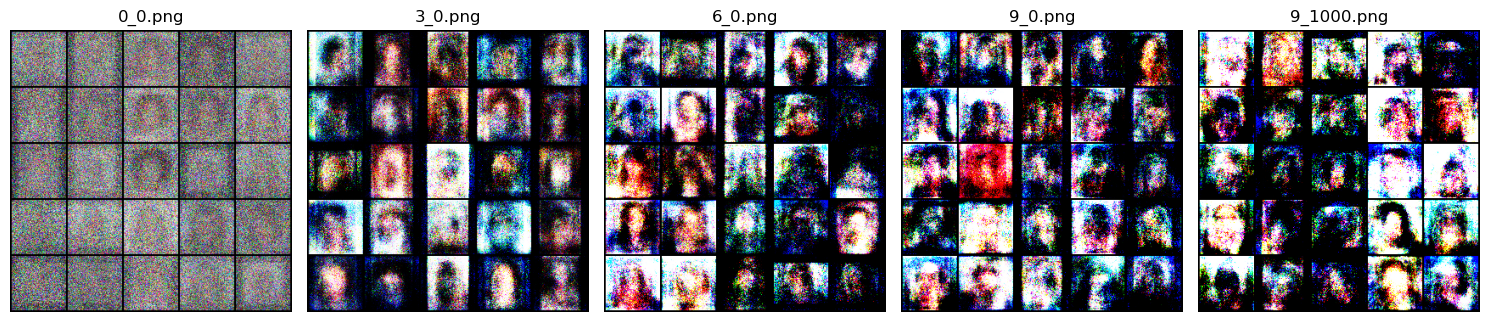

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = [f"./images_multiclass/{i}_0.png" for i in range(n_epochs) if i%3==0]+[f"./images_multiclass/{n_epochs-1}_1000.png"]

fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 10))  

for i, img_path in enumerate(image_paths):
    img = mpimg.imread(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')  
    axs[i].set_title(f"{img_path.split('/')[-1]}")

plt.tight_layout()
plt.show()

In [39]:
generated_model_save_path = "./generator_model.pth"  

torch.save({
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
}, generated_model_save_path)

print(f"Generated model saved to {model_save_path}")

Generated model saved to ./generator_model.pth


In [40]:
discriminator_model_save_path = "./discriminator_model.pth"  

torch.save({
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': optimizer_D.state_dict(),
}, discriminator_model_save_path)

print(f"Discriminator model saved to {discriminator_model_save_path}")

Discriminator model saved to ./discriminator_model.pth


In [41]:
loaded_generator = Generator(z_dim, num_classes, img_shape=(3, 64, 64)).to(device)
loaded_optimizer_G = optim.Adam(loaded_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

model_load_path = "./generator_model.pth" 
checkpoint = torch.load(model_load_path)

loaded_generator.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer_G.load_state_dict(checkpoint['optimizer_state_dict'])

loaded_generator.eval()  

print(f"Model loaded from {model_load_path}")

Model loaded from ./generator_model.pth


In [42]:
def generate_specific_class_images(generator, class_label, num_images, z_dim, device):
    noise = torch.randn(num_images, z_dim, device=device)
    labels = torch.full((num_images,), class_label, dtype=torch.long, device=device)
    with torch.no_grad():
        generated_images = generator(noise, labels)
    return generated_images  # Returns a tensor of generated images


class_label = 1
num_images = 10
generated_images = generate_specific_class_images(loaded_generator, class_label, num_images, z_dim, device)

# save_image(generated_images[0], "generated_data/generated_image.png")
# print("Generated image saved.")

In [43]:
def generate_and_save_images(generator, class_label, num_images, z_dim, device, base_dir='generated_data'):
    generator.eval()
    
    noise = torch.randn(num_images, z_dim, device=device)
    labels = torch.full((num_images,), class_label, dtype=torch.long, device=device)

    with torch.no_grad():
        generated_images = generator(noise, labels)
    
    class_dirs = {0: "Live", 1: "Print", 2: "Papercut", 3: "Replay", 4: "3D"}
    class_dir = os.path.join(base_dir, class_dirs[class_label])
    
    os.makedirs(class_dir, exist_ok=True)
    
    for i, img in enumerate(generated_images):
        img_path = os.path.join(class_dir, f"img{i+1}.png")
        save_image(img, img_path)

    generator.train()  


generate_and_save_images(generator, class_label=0, num_images=20, z_dim=z_dim, device=device)
for class_label in range(1, 5):
    generate_and_save_images(generator, class_label=class_label, num_images=5, z_dim=z_dim, device=device)

print("Image generation and saving completed.")

Image generation and saving completed.
